# Get Camera Calibration

---
### 1 Generating Correspondences
The first step to perform DLT is to generate correspondences. The cell below opens a new window. Clicking anywhere on the image should give you the pixel location of the image. Once you're done clicking, close the image window. The cell after displays the points you have clicked.

In [57]:
%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np


image_points = []
fig = plt.figure(figsize=(20,30))

img = mpimg.imread('q1/dlt1.jpeg')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    image_points.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

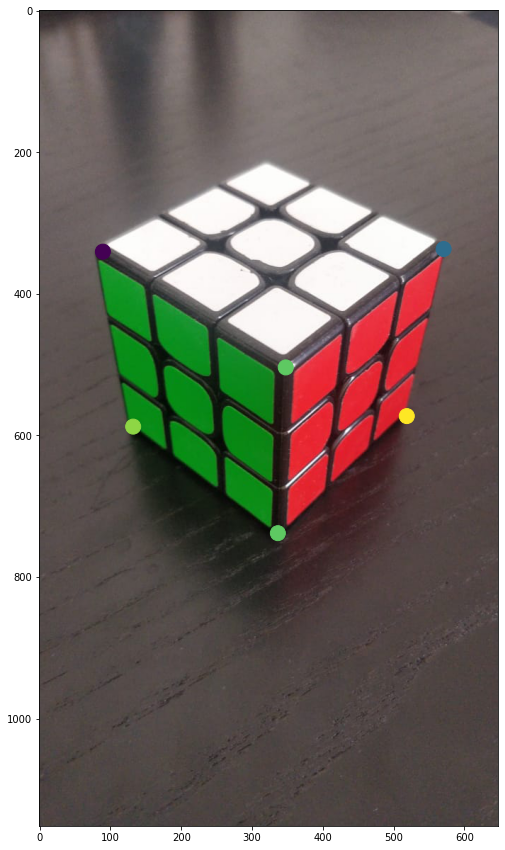

In [58]:
%matplotlib inline
N = len(image_points)
image_points = np.array(image_points)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('q1/dlt1.jpeg')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()

After generating pixel locations, you have to generate the corresponding world points. You have the freedom to chose which point you want as origin. You can consider each side as 4 units.

Ensure that the ordering of your points matches the ordering of image points. Keep track of the sequence of corners clicked.

In [59]:
x = np.ones((6, 3)) # for homogenizing
x[:, :2] = image_points
print(x)

X = []
# for 3D points
X.append([0, 4, 0, 1])
X.append([0, 0, 0, 1])
X.append([4, 0, 0, 1])

X.append([0, 4, 4, 1])
X.append([0, 0, 4, 1])
X.append([4, 0, 4, 1])
X = np.array(X)

print(X.shape, x.shape)


[[132.07304186 587.53387916   1.        ]
 [336.5095991  738.07352585   1.        ]
 [518.64398645 572.66576591   1.        ]
 [ 89.32721626 340.35149633   1.        ]
 [347.66068404 503.90074212   1.        ]
 [570.68238283 336.63446802   1.        ]]
(6, 4) (6, 3)


Now that we have the correspondences, we can estimate the P matrix. Implement the DLT function that returns the P matrix

Quick recap: x_i = P * X_i where (x_i, X_i) is the ith correspondence, and P is a 3x4 dimensional matrix. P is further decomposed as P = K * [ R | T].


In [60]:
def generate_A(x_homogeneous, X_homogeneous):
    n = x_homogeneous.shape[0]
    x, y = x_homogeneous[:, 0], x_homogeneous[:, 1]
    X, Y, Z = X_homogeneous[:, 0], X_homogeneous[:, 1], X_homogeneous[:, 2]

    A1 = np.c_[-X, -Y, -Z, -np.ones(n), np.zeros(n), np.zeros(n), np.zeros(n), np.zeros(n), np.multiply(x, X), np.multiply(x, Y), np.multiply(x, Z), x]
    A2 = np.c_[np.zeros(n), np.zeros(n), np.zeros(n), np.zeros(n), -X, -Y, -Z, -np.ones(n), np.multiply(y, X), np.multiply(y, Y), np.multiply(y, Z), y]

    # Append the rows of A1 and A2 to A in a sequential manner

    A = np.zeros((2 * n, 12))
    A[::2, :], A[1::2, :] = A1, A2
    return A

In [61]:
def DLT(x_homogeneous, X_homogeneous):
    A = generate_A(x_homogeneous, X_homogeneous)
    U, D, Vt = np.linalg.svd(A)
    p_vector = Vt[-1, :]            # get the last row of Vt, equivalent to getting last col of V
    P = p_vector.reshape((3, 4))    # transforming the p_vector to a matrix P
    return P

In [68]:
P = DLT(x, X)
print(P)

P = P/P[-1, -1]

print("The homogeneous form looks like:\n", P)

[[-7.89867824e-02  5.86097822e-02  2.02083172e-02 -4.10362365e-01]
 [ 2.43330290e-02  2.90583875e-02  1.05352004e-01 -8.99434996e-01]
 [-4.55254109e-05 -2.85966197e-05  6.74821982e-05 -1.21860742e-03]]
The homogeneous form looks like:
 [[ 6.48172504e+01 -4.80957043e+01 -1.65831234e+01  3.36746976e+02]
 [-1.99678982e+01 -2.38455691e+01 -8.64527837e+01  7.38084291e+02]
 [ 3.73585537e-02  2.34666384e-02 -5.53764871e-02  1.00000000e+00]]


### Theory

- Explain how DLT is implemented and show why it works (proof)
- When does DLT fail?

<img src="./data/1.jpeg" alt="image 1" width="400"/>   
 
<img src="./data/2.jpeg" alt="image 2" width="400"/>    

<img src="./data/3.jpeg" alt="image 3" width="400"/>    

## Analysing P

The next part of this question is to analyse how good our estimate is. Report the reprojection error of your P matrix

In [63]:
#Get reprojected points
def get_points(P, X):
    x = P @ X.T
    x_normalized = x/x[2]
    x_euclidian = x_normalized.T[:, :2]
    return x_euclidian

#Get reprojection error
def get_err(x, X, P):
    x_projected = get_points(P, X)
    print("The initial image points are:\n", x[:, :2], "\nThe projected image points found through P and X are:\n", x_projected, "\n")
    error = np.linalg.norm(x[:, :2] - x_projected, axis = 1)
    average_distance_separation = np.mean(error) # np.mean(error ** 2)
    return average_distance_separation

In [64]:
print("Reprojection Error is:", get_err(x, X, P))

The initial image points are:
 [[132.07304186 587.53387916]
 [336.5095991  738.07352585]
 [518.64398645 572.66576591]
 [ 89.32721626 340.35149633]
 [347.66068404 503.90074212]
 [570.68238283 336.63446802]] 
The projected image points found through P and X are:
 [[131.97602444 587.55065955]
 [336.74697609 738.0842912 ]
 [518.52987316 572.64059994]
 [ 89.44886439 340.3304534 ]
 [347.35587508 503.88715967]
 [570.8237406  336.66563998]] 

Reprojection Error is: 0.17104239295351328


Given the P matrix, we can estimate K, R and T. Write a function that returns K,R,T given P.
Note: 
P = K * [R | T] where K is a 3x3 matrix and [R | T], P are 3x4 matrices

In [65]:
def ret_RKT(P):

    # P = K * [R | -R * X0] = [KR | -KRX0] = [H|h]
    H, h = P[:, :3], P[:, -1]

    # Computing pseudoinverse (for cases when inverse doesn't exist)
    H_inverse = np.linalg.pinv(H)
    X0 = - H_inverse @ h

    # QR decomposition decomposes a matrix into a triangular and rotation matrix
    # QR(M) = (Rot, Tri), where M = Rot * Tri
    # H = K * R     => H^-1 = R^T * K^-1
    # If K is triangular then so is K^-1
    # And given the order of decomposition we calculate the QR decompostion of H^-1 instead of that for H.

    R_transpose, K_inverse = np.linalg.qr(H_inverse)
    K = np.linalg.pinv(K_inverse)

    # The H matrix is homogenous, => so is the calibration matrix
    # Due to its homogeneity, we normalize it

    R = R_transpose.T

    return R, K, X0



R, K, X0 = ret_RKT(P)

print("K:\n", K, "\nR:\n", R, "\nX0:", X0, "\n")


K:
 [[ 9.28368596e-02  3.91891015e-03  3.80572477e-02]
 [-8.20866150e-18 -9.45730444e-02  5.99288759e-02]
 [ 4.44419036e-17  2.02577422e-17  8.62796428e-05]] 
R:
 [[-0.60953438  0.7890262  -0.07684724]
 [-0.59165348 -0.51728566 -0.61835403]
 [-0.52764951 -0.3314411   0.78213349]] 
X0: [-6.30045087 -5.45336983 11.49679302] 



#### Verifying the R, K, T Values

Use `np.isclose` to verify the matrix

In [66]:
P_recomputed = np.zeros((3, 4))
P_recomputed[:, :3], P_recomputed[:, -1] = K @ R, - K @ R @ X0

print("The original P:\n", P, "\nThe P recomputed from its components:\n", P_recomputed, "\n")
print("The np.isclose function returns the following matrix:\n")
print(np.isclose(P, P_recomputed))


The original P:
 [[-7.89867824e-02  5.86097822e-02  2.02083172e-02 -4.10362365e-01]
 [ 2.43330290e-02  2.90583875e-02  1.05352004e-01 -8.99434996e-01]
 [-4.55254109e-05 -2.85966197e-05  6.74821982e-05 -1.21860742e-03]] 
The P recomputed from its components:
 [[-7.89867824e-02  5.86097822e-02  2.02083172e-02 -4.10362365e-01]
 [ 2.43330290e-02  2.90583875e-02  1.05352004e-01 -8.99434996e-01]
 [-4.55254109e-05 -2.85966197e-05  6.74821982e-05 -1.21860742e-03]] 

The np.isclose function returns the following matrix:

[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]


**Reproject the world points with P matrix you have obtained via DLT and visualize**

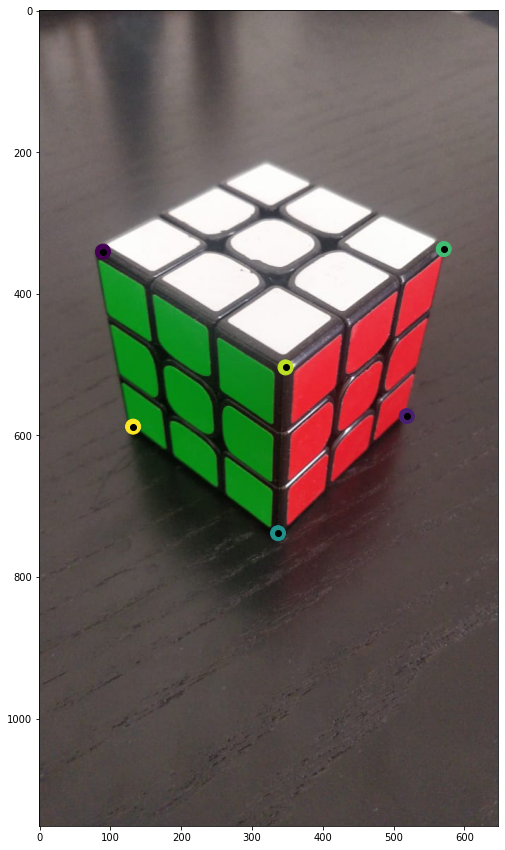

In [67]:
%matplotlib inline
reprojected_points = get_points(P, X)
N = len(reprojected_points)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('q1/dlt1.jpeg')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(reprojected_points[:, 0], reprojected_points[:, 1], c = colors, s = area)
plt.scatter(image_points[:,0], image_points[:,1], c = "black")
plt.show()

### Zhangs method

Using the inbuilt Opencv function to estimate the K matrix of a camera. The checkerboard images 5456-5470 in `q1/zhangs` folder is used for this task. 

**Reference**: https://docs.opencv.org/3.4/dc/dbb/tutorial_py_calibration.html

In [53]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mtp

[[0. 0. 0.]
 [1. 0. 0.]
 [2. 0. 0.]
 [3. 0. 0.]
 [4. 0. 0.]
 [5. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [2. 1. 0.]
 [3. 1. 0.]
 [4. 1. 0.]
 [5. 1. 0.]
 [0. 2. 0.]
 [1. 2. 0.]
 [2. 2. 0.]
 [3. 2. 0.]
 [4. 2. 0.]
 [5. 2. 0.]
 [0. 3. 0.]
 [1. 3. 0.]
 [2. 3. 0.]
 [3. 3. 0.]
 [4. 3. 0.]
 [5. 3. 0.]
 [0. 4. 0.]
 [1. 4. 0.]
 [2. 4. 0.]
 [3. 4. 0.]
 [4. 4. 0.]
 [5. 4. 0.]
 [0. 5. 0.]
 [1. 5. 0.]
 [2. 5. 0.]
 [3. 5. 0.]
 [4. 5. 0.]
 [5. 5. 0.]
 [0. 6. 0.]
 [1. 6. 0.]
 [2. 6. 0.]
 [3. 6. 0.]
 [4. 6. 0.]
 [5. 6. 0.]
 [0. 7. 0.]
 [1. 7. 0.]
 [2. 7. 0.]
 [3. 7. 0.]
 [4. 7. 0.]
 [5. 7. 0.]]


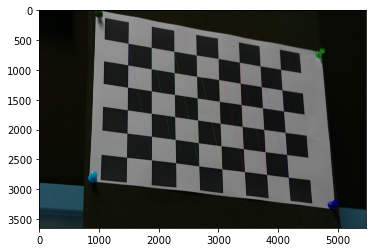

In [54]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

N, M = 6, 8 # N for rows, M for columns

world_points = np.zeros((48, 3), np.float32)
counter = 0
for i in range(M):
    for j in range(N):
        world_points[i * N + j] = np.array([j, i, 0])

print(world_points)

objp = world_points
image_points, object_points = [], []

filepath_ = 'q1/Zhangs/'

for fname in sorted(os.listdir(filepath_)):    
    fname = filepath_ + fname
    img = cv2.imread(fname)
    colorg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    flag, corners = cv2.findChessboardCorners(colorg, (N, M), None)     ## Get the chess board corners
    
    if flag == True:
        object_points.append(objp)
        corners_next = cv2.cornerSubPix(colorg,corners,(11,11),(-1,-1),criteria)
        image_points.append(corners_next)
        image_corners = cv2.drawChessboardCorners(img, (N,M), corners_next, flag)
        plt.imshow(image_corners)
        mtp.image.imsave(fname + '.pic.png', img)


In [56]:
K = cv2.calibrateCamera(object_points, image_points, colorg.shape[::-1],None,None)[1]
print(K)

[[1.36415093e+04 0.00000000e+00 3.31635835e+03]
 [0.00000000e+00 1.36632517e+04 1.50037365e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


---
### 2 Epipolar lines
#### Task 1

For this task, two images of the same scene from different view-points are used. We need to first estimate the fundamental matrix from these two images.

<img src="./q2/img1.jpg" alt="image 1" width="400"/>
<img src="./q2/img2.jpg" alt="image 2" width="400"/>

The convention used for F is $x'^{T}Fx$ where $x'$ is the location of the point in the second image. 

In [1]:
%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np
import cv2

### First we will use on-click to find 8 points so that we can apply 8-point algorithm.

In [6]:
#Opening img1
image_points = []
fig = plt.figure(figsize=(20,30))

img = mpimg.imread('q2/img1.jpg')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    image_points.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

In [7]:
#Opening img2
image_points = []
fig = plt.figure(figsize=(20,30))

img = mpimg.imread('q2/img2.jpg')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    image_points.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

In [2]:
COLOR = [[255,0,0],[0,255,0],[0,0,255],[255,255,0],[0,255,255],[255,0,255],[128,128,0],[0,128,128],[100,100,100],[200,200,200],[1,100,1,],[130,130,200],[16,69,49],[175,250,200],[100,200,0],[0,100,200],[10,255,100]]

def plot_points(points,image):
    
    for i in range(points.shape[0]):
        
        thickness = 10
        colour = COLOR[i]
        
        image = cv2.circle(image,(int(points[i][0]),int(points[i][1])),thickness,colour,-1)
    
    return image

def plot_line(image,line_coeff,i,IMG_WID):
    
    #line is of the form ax+by+c=0, where a=line_coeff[0],b=line_coeff[1],c=line_coeff[2].
        
    a = line_coeff[0]
    b = line_coeff[1]
    c = line_coeff[2]
    #We need two end points of line:
    x1 = 0
    y1 = int(-c/b)
    x2 = IMG_WID
    y2 = int(-(a*IMG_WID+c)/b)
    thickness1 = 10
    thickness2 = 5
    colour = COLOR[i]  
    image = cv2.line(image,(x1,y1),(x2,y2),colour,thickness2)
    
    return image


def epipolar_line(points_plotPoints,image_plotPoints,points_plotLine,image_plotLine,F):

    IMG_WID = image_plotLine.shape[1]
    LINE=[]
    for i in range(points_plotPoints.shape[0]):
        
        point = np.array([points_plotPoints[i][0],points_plotPoints[i][1],1])
        line_coeff = F @ point      #Finding the line's coeffient vecotor
        LINE.append(line_coeff)
        #print(line_coeff)
        #Plot line on other image
        image_plotLine = plot_line(image_plotLine,line_coeff,i,IMG_WID)

    #Plot points on both images
    image_plotPoints = plot_points(points_plotPoints,image_plotPoints)
    image_plotLine = plot_points(points_plotLine,image_plotLine)

    %matplotlib inline
    fig, ax = plt.subplots(1,2,figsize=(25,25)) 
    ax[0].imshow(image_plotPoints)
    ax[1].imshow(image_plotLine)
    return np.array(LINE)

In [3]:
#Defining number of points to be used 
N_POINT_ALGO = 8       # 8-point algorithm


#Writing out the points found using on-click

#points1 = np.array([[381,402],[452,497],[671,538],[501,254],[506,381],[474,440],[471,537],[498,364],[706,319],[635,367]])
#points2 = np.array([[390,346],[439,412],[651,417],[477,194],[482,300],[456,359],[454,444],[475,287],[686,185],[606,253]])

points1 = np.array([[379.8,100],[257.8,466.5],[663.1,377.6],[500.6,259.6],[444,457.8],[736.1,608.83],[804.81,216.41],[943.15,616.52]])
points2 = np.array([[394.98,106.81],[315.92,419.76],[637.26,256.05],[477.38,196.96],[434.15,380.47],[711.8,479],[821.05,44.85],[1093.39,471.02]])

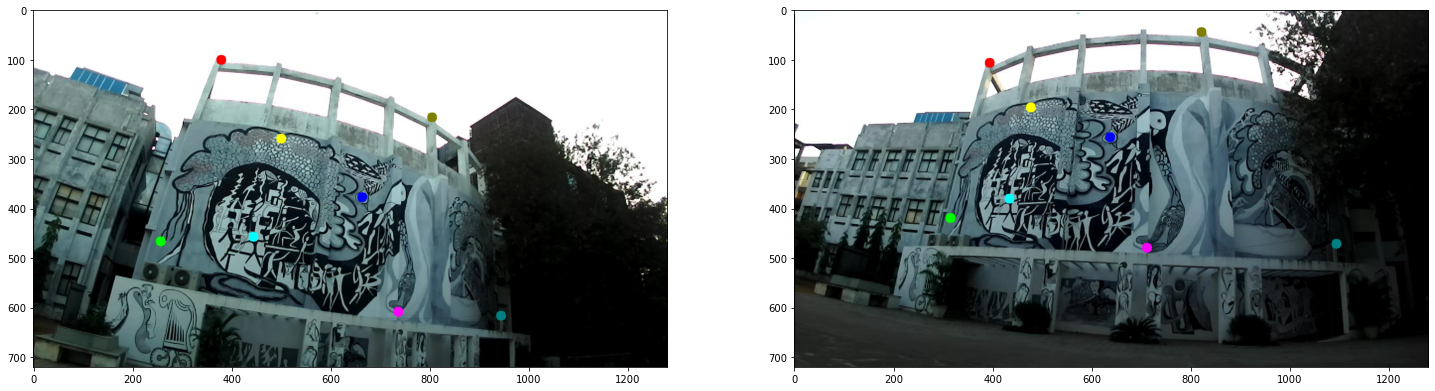

In [4]:
#View the points:

#Points1 - corresponding to image 1
img1 = plt.imread('q2/img1.jpg')
img1 = plot_points(points1,img1)

#Points2 - corresponding to image 2
img2 = plt.imread('q2/img2.jpg')
img2 = plot_points(points2,img2)

%matplotlib inline
fig, ax = plt.subplots(1,2,figsize=(25,25)) 
ax[0].imshow(img1)
ax[1].imshow(img2)

In [9]:
#Normalisation: 

def get_T(lmbda,mu):
    T = np.array([[lmbda,0,-mu[0]*lmbda],[0,lmbda,-mu[1]*lmbda],[0,0,1]])
    return T
    
mean1 = np.mean(points1,axis=0)
mean2 = np.mean(points2,axis=0)

norm_points1 = points1 - mean1
norm_points2 = points2 - mean2

lmbda1 = np.sqrt((2*N_POINT_ALGO)/(np.sum(norm_points1*norm_points1)))
lmbda2 = np.sqrt((2*N_POINT_ALGO)/(np.sum(norm_points2*norm_points2)))

norm_points1 = lmbda1 * norm_points1
norm_points2 = lmbda2 * norm_points2

T1 = get_T(lmbda1,mean1)
T2 = get_T(lmbda2,mean2)


In [10]:
#Define W matrix 

W = np.array([norm_points2[0][0]*norm_points1[0][0],norm_points2[0][0]*norm_points1[0][1],norm_points2[0][0],
                        norm_points2[0][1]*norm_points1[0][0],norm_points2[0][1]*norm_points1[0][1],norm_points2[0][1],norm_points1[0][0],norm_points1[0][1],1])
for i in range(1,N_POINT_ALGO):
    w = np.array([norm_points2[i][0]*norm_points1[i][0],norm_points2[i][0]*norm_points1[i][1],norm_points2[i][0],
                        norm_points2[i][1]*norm_points1[i][0],norm_points2[i][1]*norm_points1[i][1],norm_points2[i][1],norm_points1[i][0],norm_points1[i][1],1])
    W = np.vstack((W,w))

print(W.shape)

(8, 9)


### We find F such that WF=0 , where F is a column vector of size 9

In [11]:
#Decompose W using SVD to find F
#Now we will use SVD as :
U, D, Vt = np.linalg.svd(W)
V = Vt.T

#So an estimate of F will be the last column of V matrix
F_temp = V[:,-1]
F_temp = F_temp.reshape((3,3))      #reshape F into 3x3 matrix

#As this esitmate dows not have the proper constraints, we need to perform its SVD and add the constraint in its D matrix.
U, D, Vt = np.linalg.svd(F_temp)
D[-1] = 0       #Last element of diagonal matrix is made 0
D = np.diag(D)
F_est = U @ D @ Vt     #Get estimated F

#Denormalisation:
F = T2.T @ F_est @ T1
F = F/F[2][2]
print(F)

[[ 4.86970257e-07 -1.15301424e-06 -7.60230723e-05]
 [ 4.19869543e-06  3.85614221e-07 -7.00488210e-03]
 [-2.37413926e-03  4.59769437e-03  1.00000000e+00]]


### Now that we have the fundamental matrix, we can plot the epipolar lines 

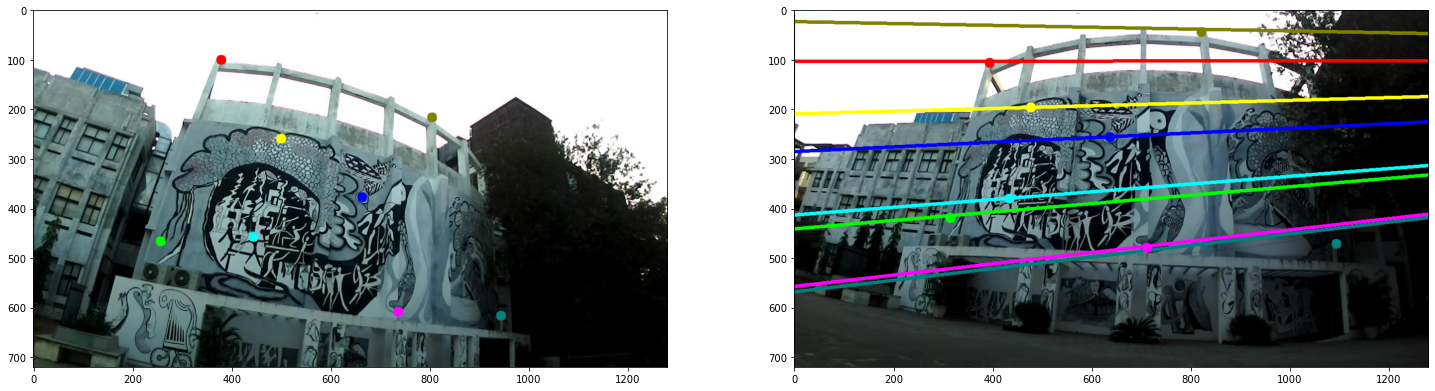

In [12]:
#Plotting points on image 1 and corresponding lines on image 2 
img1 = plt.imread('q2/img1.jpg')
img2 = plt.imread('q2/img2.jpg')
lines2 = epipolar_line(points1,img1,points2,img2,F)


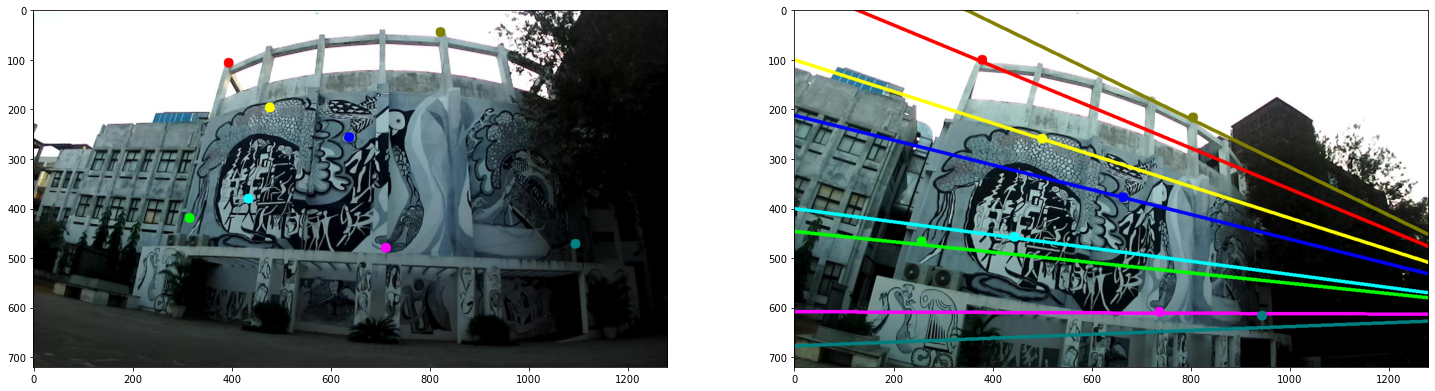

In [13]:
#Plotting points on image 2 and corresponding lines on image 1

img1 = plt.imread('q2/img1.jpg')
img2 = plt.imread('q2/img2.jpg')
lines1 = epipolar_line(points2,img2,points1,img1,F.T)

**Provide a clear explanation on your approach for both this task and the next**

## Task-1 

First we need to find correspondences between the two images, so we have selected points manually using on-click.
Now that we have the points, we will apply the 8-point alogrithm, which in steps is explained below:  

### 1.Normalisation
This step requires us to Normalise the input points of both the images. We do so by 
1. Shifting all the points to their mean:     
    
    $P_1$ : points of image-1 , $mu_1$ : mean of $P_1$  
    So, shifting:  
    $P_1\_shifted = P_1-mu_1$  

    
    $P_2$ : points of image-2 , $mu_2$ : mean of $P_2$  
    So, shifting:  
    $P_2\_shifted = P_2-mu_2$
    
2. Find the scaling parameter which makes the squared mean of these shifted points equal to 2 pixels.   

    $lambda_1$ = scaling parameter of $P_1\_shifted$  
    $norm-points_1 = lambda_1 * P_1\_shifted$  

    $lambda_2$ = scaling parameter of $P_2\_shifted$  
    $norm-points_2 = lambda_2 * P_2\_shifted$  

    Define $T_1$ corresponding to $lambda_1$ and $mu_1$ and $T_2$ corresponding to $lambda_2$ and $mu_2$.

### 2.Defining W

Now we will define W as:     
    
$norm-points_2 \space F \space norm-points_1 = 0$

So we will have $W \space F = 0$ 

Now we will use SVD so that : $U,\space D, \space Vt = SVD(W)$    
$F$ = last row of Vt  

### 3.Adding the constraints in F
We need to make $det(F) = 0$  

So we perform:  $U,\space D, \space Vt = SVD(F)$  
$D[last element]=0$   
$F = U\space D \space Vt$   

### 4.De-Normalise
The F we found was for normalised.    
So we de-normalise $F$ as:  
    $F_(final) = T_2^T\space F \space T_1$


Having done these steps, we get Fundamental Matrix : $F_(final)$
### Plotting the epipolar lines:
We are given notation: $x'^{T}Fx=0$.  
Now to find the epipolar lines, we know:  

Equation of line of points of first image on second image is  $ F   x $, where $x$ is a point on the first image.  
Equation of line of points of second image on first image is  $ F^T   x $, where $x$ is a point on the first image.

The equation of line obtained is of the form: $ax+by+c=0$, and we get $a,b$ and $c$ from above.
Having found the line, we plot the line by taking it's endpoints on the image plane. That is we get one endpoint by making x=0. Another point is found by making $x$ =maximum x-coordinate possible from image.

Having these two points, we plot the epipolar line.

#### Task 2
Report the location of the epipoles. Mathematically find the epipoles and verify that the lines intersect at the epipole.

We are given notation: $x'^{T}Fx=0$, where $F$ is Fundamental Matrix, $x$ is points on first image and $x'$ is points on second image.  

Now for any point $x$ on first image, it's epipolar line on second image is $L' = F\space x$. Now for epipole $e'$ on second image, it will lie on the line $L'$, so $e'^T \space L' =0$. Hence we have $e'^T \space F=0$. Or taking transpose, we have: $F^T \space e'=0$. So, epipole of second image = $nullspace(F^T)$

Now for any point $x'$ on second image, it's epipolar line on first image is $L = F^T\space x'$. Now for epipole $e$ on first image, it will lie on the line $'$, so $e^T \space L =0$.  Hence we have $e^T \space F^T=0$. Or taking transpose, we have: $F \space e=0$. So, epipole of first image = $nullspace(F)$.

The null-spaces are found using least squares approach by SVD.

In [14]:
def epipole(M):
    U, D, Vt = np.linalg.svd(M)
    V = Vt.T
    clm = V[:,-1]
    return clm

In [15]:
#The epipoles are calculated as follows

#For image-1
e1 = epipole(F)
e1 = e1/e1[2]
print("Epipole of first image is at: ",e1[0],e1[1])

#For image-2
e2 = epipole(F.T) 
e2 = e2/e2[2]
print("Epipole of second image is at: ",e2[0],e2[1])

Epipole of first image is at:  1611.879874291686 614.8358432583199
Epipole of second image is at:  4020.6936423051843 99.12151356415863


In [16]:
print(lines1)
lines1 = lines1.T

[[-1.73333309e-03  4.18346426e-03  2.21780949e-01]
 [-4.57851225e-04  4.39529953e-03 -1.96438652e+00]
 [-9.88736631e-04  3.96166103e-03 -8.42046526e-01]
 [-1.31469435e-03  4.12321901e-03 -4.15973474e-01]
 [-5.65243475e-04  4.24382788e-03 -1.69815291e+00]
 [-1.63387224e-05  3.96168804e-03 -2.40945175e+00]
 [-1.78600084e-03  3.66830682e-03  6.23412294e-01]
 [ 1.35978668e-04  3.51863214e-03 -2.38256244e+00]]


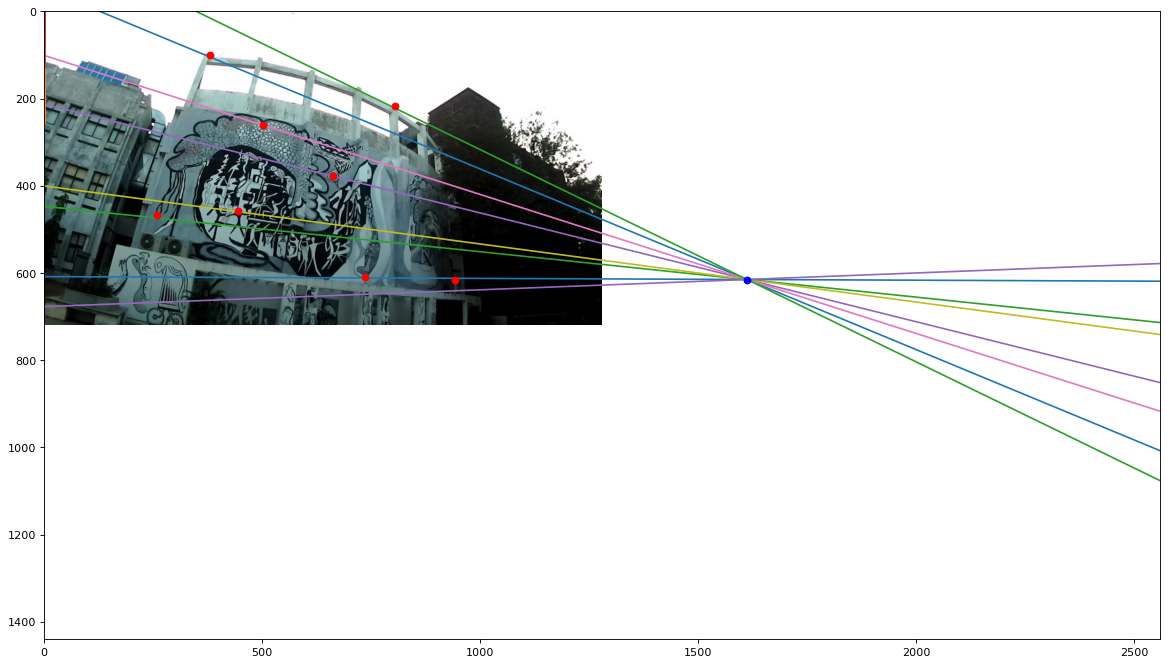

In [152]:
#Visualising the epipole of image 1
img1 = plt.imread('q2/img1.jpg')
ig = plt.figure(figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
imgplot = plt.imshow(img1)

(r, c, d) = img1.shape
plt.xlim(0, 2*c)
plt.ylim(0, 2*r)

for j in range(lines1.shape[1]):
    l = lines1[:, j]
    
    x = np.linspace(-c, 2*c, 100)
    y = -(l[0]*x + l[2])/l[1]
    plt.plot(x, y, COLOR[j])
    plt.plot(points1[j, 0], points1[j, 1], 'ro')

plt.plot(e1[0], e1[1], 'bo')
    
plt.gca().invert_yaxis()
plt.show()

#epipolar_line_single(points2,points1,img1,F.T)

In [17]:
print(lines2)
lines2 = lines2.T

[[-6.37319301e-06 -5.37165616e-03  5.58071345e-01]
 [-4.88363284e-04 -5.74256939e-03  2.53277132e+00]
 [-1.88491273e-04 -4.07511924e-03  1.16179765e+00]
 [-1.31568259e-04 -4.80290972e-03  1.00506734e+00]
 [-3.87658198e-04 -4.96412714e-03  2.05070665e+00]
 [-4.19553927e-04 -3.67944889e-03  2.05161035e+00]
 [ 6.63716479e-05 -3.54227926e-03  8.42560193e-02]
 [-3.27593415e-04 -2.80714363e-03  1.59540109e+00]]


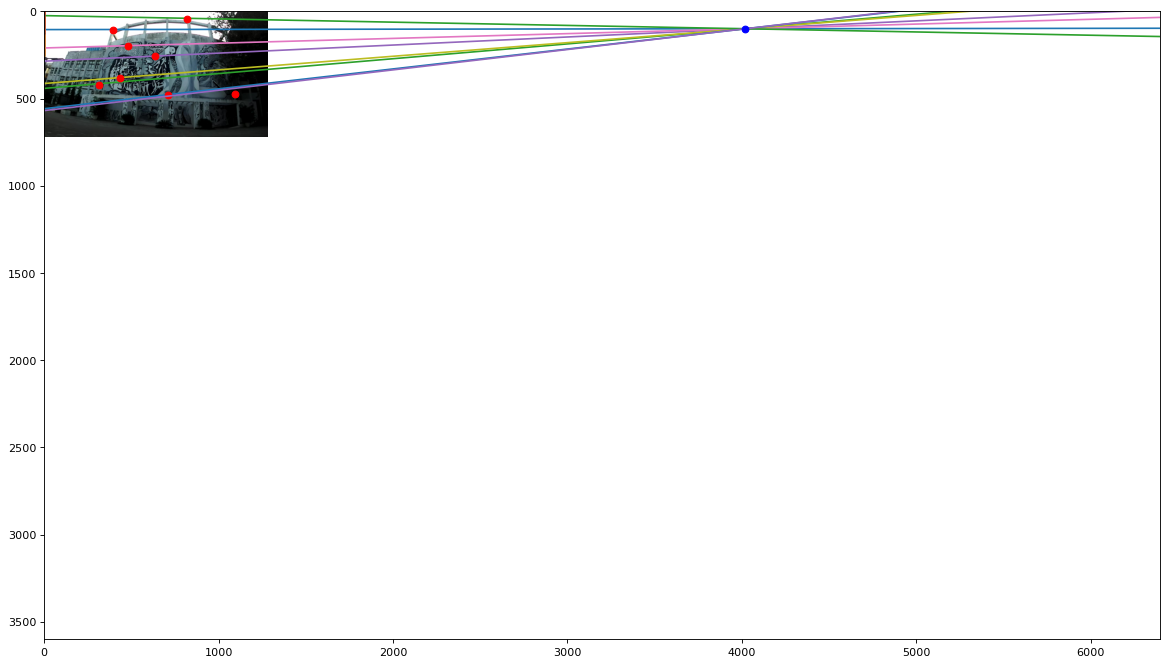

In [154]:
#Visualising the epipole of image 2
img2 = plt.imread('q2/img2.jpg')
ig = plt.figure(figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
imgplot = plt.imshow(img2)

(r, c, d) = img2.shape
plt.xlim(0, 5*c)
plt.ylim(0, 5*r)

for j in range(lines2.shape[1]):
    l = lines2[:, j]
    
    x = np.linspace(-c, 5*c, 100)
    y = -(l[0]*x + l[2])/l[1]
    plt.plot(x, y, COLOR[j])
    plt.plot(points2[j, 0], points2[j, 1], 'ro')

plt.plot(e2[0], e2[1], 'bo')
    
plt.gca().invert_yaxis()
plt.show()

#epipolar_line_single(points2,points1,img1,F.T)

### Verifying the Epipoles Mathematically

In [18]:
def line_intersect(a1, b1, a2, b2):
    alpha = (b1 - b2)/(a1 - a2)/b1
    x_ = alpha/(1 - alpha * a1)
    y_ = - (1 + a1 * x_)/b1
    return [x_, y_]

lines1 = lines1.T
lines2 = lines2.T

print('Epipole 1:')
for i in range(7):
    print(line_intersect(lines1[i][0]/lines1[i][2], lines1[i][1]/lines1[i][2], lines1[i+1][0]/lines1[i+1][2], lines1[i+1][1]/lines1[i+1][2]))

print('Epipole 2:')
for i in range(7):
    print(line_intersect(lines2[i][0]/lines2[i][2], lines2[i][1]/lines2[i][2], lines2[i+1][0]/lines2[i+1][2], lines2[i+1][1]/lines2[i+1][2]))

Epipole 1:
[1611.8798742916397, 614.8358432582882]
[1611.879874291641, 614.835843258289]
[1611.8798742916445, 614.8358432582899]
[1611.8798742916424, 614.8358432582892]
[1611.879874291641, 614.8358432582892]
[1611.8798742916422, 614.8358432582893]
[1611.8798742916417, 614.835843258289]
Epipole 2:
[4020.693642304972, 99.1215135641574]
[4020.693642304971, 99.12151356415747]
[4020.693642304974, 99.12151356415734]
[4020.6936423049733, 99.12151356415734]
[4020.693642304974, 99.12151356415727]
[4020.6936423049733, 99.12151356415737]
[4020.693642304974, 99.12151356415744]


### If more than 8 points are taken:
Here we experimented and took more than 8 points. Specifically, we took 16 points.

In [120]:
#Opening img1
%matplotlib tk
image_points = []
fig = plt.figure(figsize=(20,30))

img = mpimg.imread('q2/img1.jpg')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    image_points.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

points1 = image_points
imgplot = plt.imshow(img)
plt.show()

In [121]:
#Opening img2
%matplotlib tk
image_points = []
fig = plt.figure(figsize=(20,30))

img = mpimg.imread('q2/img2.jpg')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    image_points.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

points2 = image_points
imgplot = plt.imshow(img)
plt.show()

In [122]:
#Defining number of points to be used 
N_POINT_ALGO = 16       # 16-point algorithm

points1 = np.array(points1)
points2 = np.array(points2)

print(points1)
print(points2)

[[372.7284266   96.23347217]
 [498.08081278 107.80446166]
 [616.68345509 137.69618452]
 [721.78660966 178.19464775]
 [807.60478174 217.72886185]
 [321.623223   316.08227255]
 [356.33619148 287.15479881]
 [396.83465471 262.08432158]
 [432.51187232 248.58483383]
 [500.97356016 261.12007245]
 [581.00623749 277.51230757]
 [257.98278079 466.50513597]
 [234.8408018  527.25283081]
 [300.40974226 541.71656767]
 [564.61400237 613.07100289]
 [620.54045159 618.85649763]]
[[393.94190734 109.73295991]
 [477.83158117  75.98424055]
 [582.93473574  49.94951419]
 [703.46587629  42.2355212 ]
 [826.88976423  43.19977032]
 [355.37194236 297.76153918]
 [375.62117397 261.12007245]
 [402.62014946 233.15684784]
 [427.69062669 210.01486886]
 [477.83158117 201.33662674]
 [547.25751813 191.69413549]
 [316.80197738 418.29267974]
 [276.30351415 466.50513597]
 [324.51597038 470.36213246]
 [473.01033555 494.46836058]
 [522.18704089 491.5756132 ]]


In [129]:
bck_points1 = points1
bck_points2 = points2

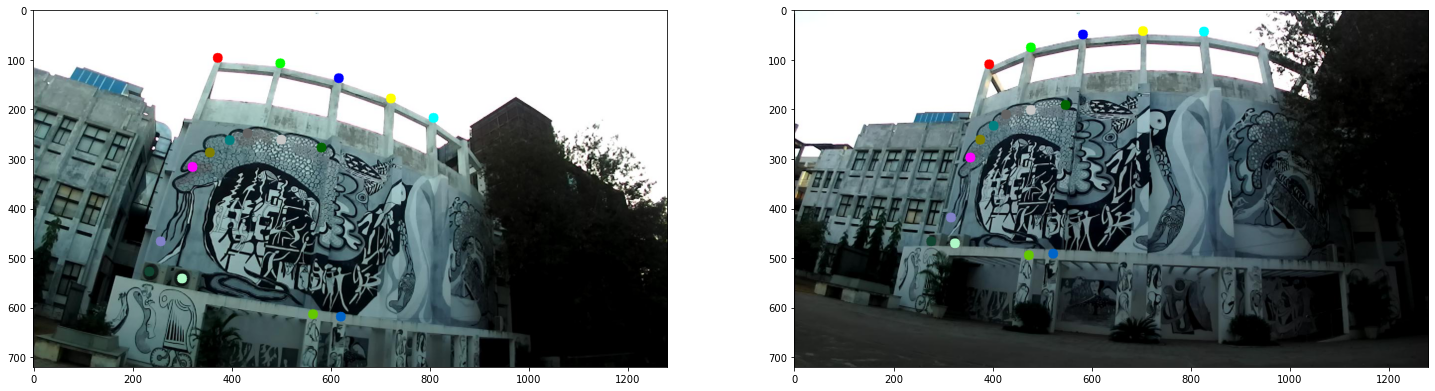

In [123]:
#View the points:

#Points1 - corresponding to image 1
img1 = plt.imread('q2/img1.jpg')
img1 = plot_points(points1,img1)

#Points2 - corresponding to image 2
img2 = plt.imread('q2/img2.jpg')
img2 = plot_points(points2,img2)

%matplotlib inline
fig, ax = plt.subplots(1,2,figsize=(25,25)) 
ax[0].imshow(img1)
ax[1].imshow(img2)

In [125]:
#Normalisation: 

def get_T(lmbda,mu):
    T = np.array([[lmbda,0,-mu[0]*lmbda],[0,lmbda,-mu[1]*lmbda],[0,0,1]])
    return T
    
mean1 = np.mean(points1,axis=0)
mean2 = np.mean(points2,axis=0)

norm_points1 = points1 - mean1
norm_points2 = points2 - mean2

lmbda1 = np.sqrt((2*N_POINT_ALGO)/(np.sum(norm_points1*norm_points1)))
lmbda2 = np.sqrt((2*N_POINT_ALGO)/(np.sum(norm_points2*norm_points2)))

norm_points1 = lmbda1 * norm_points1
norm_points2 = lmbda2 * norm_points2

T1 = get_T(lmbda1,mean1)
T2 = get_T(lmbda2,mean2)


#Define W matrix 

W = np.array([norm_points2[0][0]*norm_points1[0][0],norm_points2[0][0]*norm_points1[0][1],norm_points2[0][0],
                        norm_points2[0][1]*norm_points1[0][0],norm_points2[0][1]*norm_points1[0][1],norm_points2[0][1],norm_points1[0][0],norm_points1[0][1],1])
for i in range(1,N_POINT_ALGO):
    w = np.array([norm_points2[i][0]*norm_points1[i][0],norm_points2[i][0]*norm_points1[i][1],norm_points2[i][0],
                        norm_points2[i][1]*norm_points1[i][0],norm_points2[i][1]*norm_points1[i][1],norm_points2[i][1],norm_points1[i][0],norm_points1[i][1],1])
    W = np.vstack((W,w))

print(W.shape)

#Decompose W using SVD to find F
#Now we will use SVD as :
U, D, Vt = np.linalg.svd(W)
V = Vt.T

#So an estimate of F will be the last column of V matrix
F_temp = V[:,-1]
F_temp = F_temp.reshape((3,3))      #reshape F into 3x3 matrix

#As this esitmate dows not have the proper constraints, we need to perform its SVD and add the constraint in its D matrix.
U, D, Vt = np.linalg.svd(F_temp)
D[-1] = 0       #Last element of diagonal matrix is made 0
D = np.diag(D)
F_est = U @ D @ Vt     #Get estimated F

#Denormalisation:
F = T2.T @ F_est @ T1
F = F/F[2][2]
print(F)

(16, 9)
[[-2.57274377e-07  4.42316584e-07  1.57862029e-04]
 [ 2.96740608e-06  2.18816039e-07 -6.76669140e-03]
 [-2.20595777e-03  4.17291307e-03  1.00000000e+00]]


array([[ 1.04534215e-04, -5.63959737e-03,  5.79350745e-01],
       [ 7.74022988e-05, -5.26509402e-03,  3.51113409e-01],
       [ 6.01104827e-05, -4.90661103e-03,  2.14216550e-01],
       [ 5.09832759e-05, -4.58586558e-03,  1.51359996e-01],
       [ 4.63910977e-05, -4.32255749e-03,  1.27021571e-01],
       [ 2.14925045e-04, -5.74314082e-03,  1.60949660e+00],
       [ 1.93199186e-04, -5.64646314e-03,  1.41220942e+00],
       [ 1.71690882e-04, -5.53177358e-03,  1.21825460e+00],
       [ 1.56541000e-04, -5.42885869e-03,  1.08321998e+00],
       [ 1.44472106e-04, -5.22296215e-03,  9.84504846e-01],
       [ 1.31132306e-04, -4.98188581e-03,  8.76359511e-01],
       [ 2.97832627e-04, -5.89907292e-03,  2.37758626e+00],
       [ 3.30656178e-04, -5.95445200e-03,  2.68213134e+00],
       [ 3.20184521e-04, -5.75671743e-03,  2.59784494e+00],
       [ 2.83772784e-04, -4.95710261e-03,  2.31277735e+00],
       [ 2.71943362e-04, -4.78988016e-03,  2.21354834e+00]])

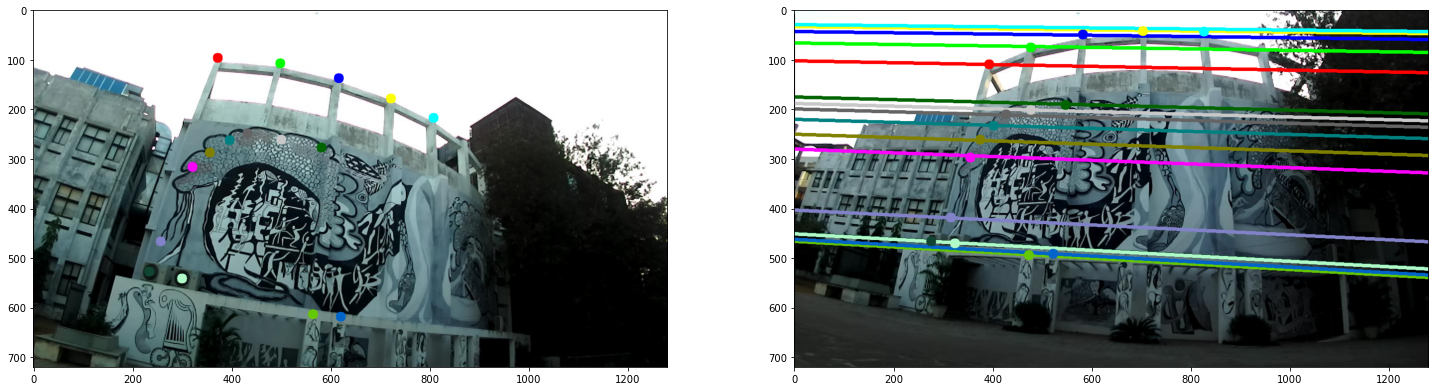

In [126]:
#Plotting points on image 1 and corresponding lines on image 2 
img1 = plt.imread('q2/img1.jpg')
img2 = plt.imread('q2/img2.jpg')
epipolar_line(points1,img1,points2,img2,F)

array([[-1.98168667e-03,  4.37117144e-03,  3.19659392e-01],
       [-2.10341549e-03,  4.40089247e-03,  5.61269556e-01],
       [-2.20771145e-03,  4.44168452e-03,  7.54030312e-01],
       [-2.26161157e-03,  4.49330950e-03,  8.25255812e-01],
       [-2.29050406e-03,  4.54811292e-03,  8.38214981e-01],
       [-1.41380646e-03,  4.39525497e-03, -9.58760711e-01],
       [-1.52774618e-03,  4.39619380e-03, -7.07622628e-01],
       [-1.61767057e-03,  4.40201709e-03, -5.14142004e-01],
       [-1.69279221e-03,  4.40804234e-03, -3.53589697e-01],
       [-1.73144406e-03,  4.42832158e-03, -2.86951358e-01],
       [-1.77791876e-03,  4.45691989e-03, -2.10743876e-01],
       [-1.04621856e-03,  4.40456898e-03, -1.78044648e+00],
       [-8.92733403e-04,  4.39720550e-03, -2.11307846e+00],
       [-8.93691958e-04,  4.41937464e-03, -2.13156665e+00],
       [-8.60362785e-04,  4.49033099e-03, -2.27124443e+00],
       [-8.81598648e-04,  4.51144968e-03, -2.24390697e+00]])

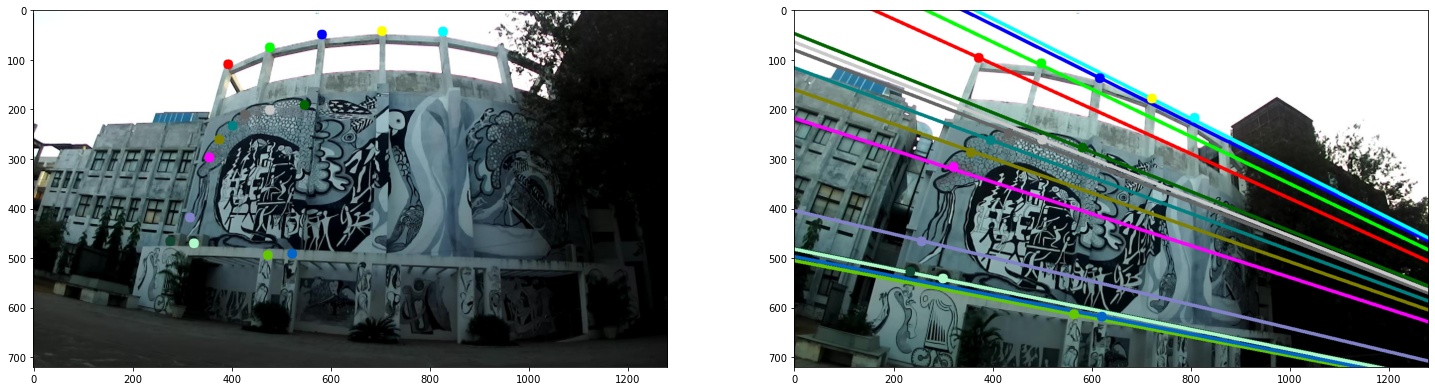

In [127]:
#Plotting points on image 2 and corresponding lines on image 1

img1 = plt.imread('q2/img1.jpg')
img2 = plt.imread('q2/img2.jpg')
epipolar_line(points2,img2,points1,img1,F.T)

In [128]:
#The epipoles are calculated as follows

#For image-1
e1 = epipole(F)
e1 = e1/e1[2]
print("Epipole of first image is at: ",e1[0],e1[1])

#For image-2
e2 = epipole(F.T) 
e2 = e2/e2[2]
print("Epipole of second image is at: ",e2[0],e2[1])

Epipole of first image is at:  2211.7907139002073 929.5944690635789
Epipole of second image is at:  -9398.858114650315 -71.48586794062983


____
### 3 Drawing a bounding box around a car and localizing it in the camera frame
An image is taken from a self-driving car, that shows another car in front. The camera has been placed on top of the car, 1.65 m from the ground, and assume the image plane is perfectly perpendicular to the ground. Given K value, we have to draw a 3D-bounding box around the car in front as shown. Our approach involves placing eight points in the 3D world such that they surround all the corners of the car, then project them onto the image, and connect the projected image points using lines.

![Kitti car](./q3/image.png)

In [27]:
%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np
import cv2

In [28]:
%matplotlib tk

#Opening image
image_points = []
fig = plt.figure(figsize=(20,30))

img = mpimg.imread('q3/image.png')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    image_points.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

In [29]:
#Camera Intrinsic Matrix 
K = np.array([[7.2153e+02,0,6.0955e+02],[0,7.2153e+02,1.7285e+02],[0,0,1]])

#Dimensions of the car
l = 4.10
w = 1.51
h = 1.38 

#Rotation Angle in degrees
ANGLE = 3

### The world frame is taken slightly behind the rear left wheel of the black car. So we will first find the translation vector to it in the camera frame.

<img src="./data/4.jpeg" alt="image 1" width="400"/>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


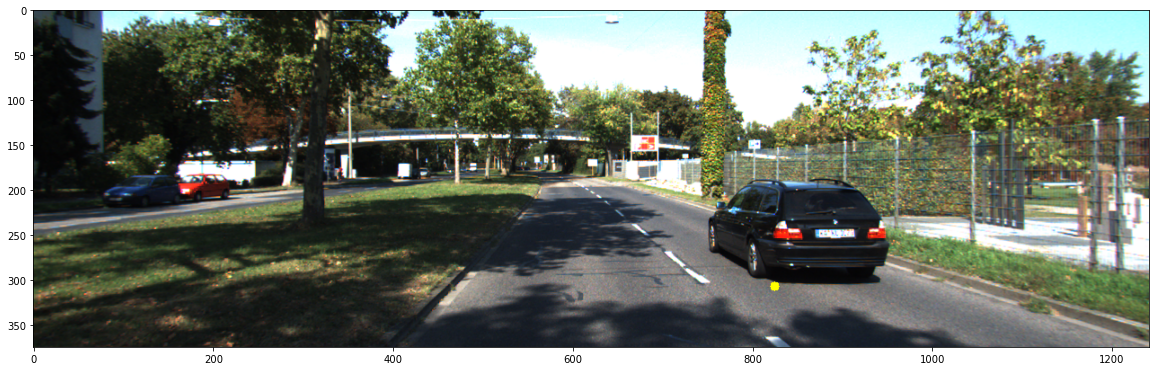

In [30]:
#The image co-ordinates of the world frame origin are found using on-click

x = 825.2741935483871
y = 307.157379032258
# x = image_points[0][0]
# y = image_points[0][1]

%matplotlib inline
fig = plt.figure(figsize=(20,30))
image = plt.imread('q3/image.png')
thickness = 5
colour = [255,255,0]
image = cv2.circle(image,(int(x),int(y)),thickness,colour,-1)
plt.imshow(image)

In [31]:
def get_rotation_matrix(alpha,beta,gama):
    R = np.zeros((3,3))
    R[0,0] = np.cos(alpha)*np.cos(beta)
    R[0,1] = np.cos(alpha)*np.sin(beta)*np.sin(gama) - np.sin(alpha)*np.cos(gama) 
    R[0,2] = np.cos(alpha)*np.sin(beta)*np.cos(gama) + np.sin(alpha)*np.sin(gama)
    R[1,0] = np.sin(alpha)*np.cos(beta) 
    R[1,1] = np.sin(alpha)*np.sin(beta)*np.sin(gama) + np.cos(alpha)*np.cos(gama)
    R[1,2] = np.sin(alpha)*np.sin(beta)*np.cos(gama) - np.cos(alpha)* np.sin(gama)
    R[2,0] = -1*np.sin(beta)
    R[2,1] = np.cos(beta)*np.sin(gama)
    R[2,2] = np.cos(beta)*np.cos(gama)
    return R

In [32]:
#Estimating translation vector to the world origin
xi = np.array([[x],[y],[1]])    #Homogeneous image co-ordinates

# As x_image = K @ X_camera , so X_camera = K^-1 @ x_image
Tc_w = np.linalg.inv(K) @ xi
#Now we need to scale Tc_w so that y-co-ord. of Tc_w = 1.65
Tc_w = 1.65/Tc_w[1][0] * Tc_w
print('The translation vector to the world origin in camera frame is:',Tc_w[0][0],Tc_w[1][0],Tc_w[2][0])

#Now defining the Rotation Matrix
alpha = 0
beta = -ANGLE*np.pi/180
gama = 0
Rc_w = get_rotation_matrix(alpha,beta,gama)
print('\nThe Rotation Matrix from camera to world frame is:\n',Rc_w)

R_T = np.hstack((Rc_w,Tc_w))
print('\nThe Transformation Matrix of dim 3x4 is:\n',R_T)


The translation vector to the world origin in camera frame is: 2.6502260852648134 1.6499999999999997 8.864177892370746

The Rotation Matrix from camera to world frame is:
 [[ 0.99862953 -0.         -0.05233596]
 [ 0.          1.         -0.        ]
 [ 0.05233596  0.          0.99862953]]

The Transformation Matrix of dim 3x4 is:
 [[ 0.99862953 -0.         -0.05233596  2.65022609]
 [ 0.          1.         -0.          1.65      ]
 [ 0.05233596  0.          0.99862953  8.86417789]]


In [33]:
#Now we will define all the 8 corners of the car w.r.t the world frame

X= np.zeros((8,4))

X[0] = np.array([0,0,0,1])        #Rear bottom-left
X[1] = np.array([w,0,0,1])        #Rear bottom right
X[2] = np.array([0,-h,0,1])       #Rear top left
X[3] = np.array([w,-h,0,1])       #Rear top right

X[4] = np.array([0,0,l,1])        #Front bottom left
X[5] = np.array([w,0,l,1])        #Front bottom right
X[6] = np.array([0,-h,l,1])       #Front top left
X[7] = np.array([w,-h,l,1])       #Front top right

print(X)


[[ 0.    0.    0.    1.  ]
 [ 1.51  0.    0.    1.  ]
 [ 0.   -1.38  0.    1.  ]
 [ 1.51 -1.38  0.    1.  ]
 [ 0.    0.    4.1   1.  ]
 [ 1.51  0.    4.1   1.  ]
 [ 0.   -1.38  4.1   1.  ]
 [ 1.51 -1.38  4.1   1.  ]]


In [34]:
#The points in image frame can be found using x = K @ R @ T @ X ,where X = corners of point in world frame
x = K @ R_T @ X.T
x = x.T

#Homogenising the points
for i in range(8):
    for j in range(3):
        x[i][j] = x[i][j]/x[i][2]

print('The image points are:\n',x)

The image points are:
 [[825.27419355 307.15737903   1.        ]
 [945.02645713 305.97056195   1.        ]
 [825.27419355 194.82757111   1.        ]
 [945.02645713 194.63336468   1.        ]
 [745.16643568 264.72167349   1.        ]
 [827.79674324 264.16479359   1.        ]
 [745.16643568 187.88354657   1.        ]
 [827.79674324 187.79242077   1.        ]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


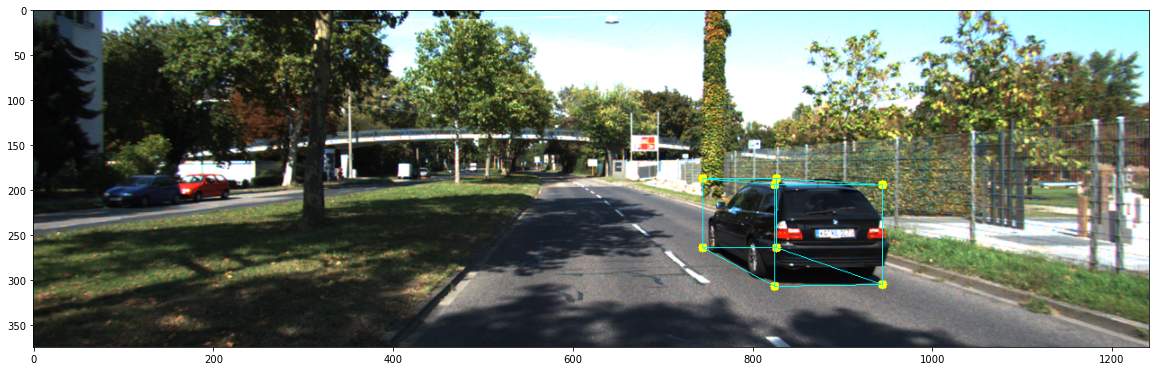

In [35]:
#Plotting the points and lines

%matplotlib inline
fig = plt.figure(figsize=(20,30))
im = plt.imread('q3/image.png')

for i in range(8):
    thickness = 5
    colour = [255,255,0]
    im = cv2.circle(im,(int(x[i][0]),int(x[i][1])),thickness,colour,-1)

thickness = 1
colour = [0,255,255]
im = cv2.line(im,(int(x[0][0]),int(x[0][1])),(int(x[1][0]),int(x[1][1])),colour,thickness)
im = cv2.line(im,(int(x[0][0]),int(x[0][1])),(int(x[2][0]),int(x[2][1])),colour,thickness)
im = cv2.line(im,(int(x[0][0]),int(x[0][1])),(int(x[4][0]),int(x[4][1])),colour,thickness)
im = cv2.line(im,(int(x[2][0]),int(x[2][1])),(int(x[3][0]),int(x[3][1])),colour,thickness)
im = cv2.line(im,(int(x[2][0]),int(x[2][1])),(int(x[6][0]),int(x[6][1])),colour,thickness)
im = cv2.line(im,(int(x[1][0]),int(x[1][1])),(int(x[3][0]),int(x[3][1])),colour,thickness)
im = cv2.line(im,(int(x[1][0]),int(x[1][1])),(int(x[5][0]),int(x[5][1])),colour,thickness)
im = cv2.line(im,(int(x[4][0]),int(x[4][1])),(int(x[5][0]),int(x[5][1])),colour,thickness)
im = cv2.line(im,(int(x[3][0]),int(x[3][1])),(int(x[7][0]),int(x[7][1])),colour,thickness)
im = cv2.line(im,(int(x[4][0]),int(x[4][1])),(int(x[6][0]),int(x[6][1])),colour,thickness)
im = cv2.line(im,(int(x[6][0]),int(x[6][1])),(int(x[7][0]),int(x[7][1])),colour,thickness)
im = cv2.line(im,(int(x[5][0]),int(x[5][1])),(int(x[7][0]),int(x[7][1])),colour,thickness)

plt.imshow(im)

In [36]:
#Estimating the translational vector to the mid point of rear end:
#It can be estimated using the vector Tc_w. It is the position vector of world origing in camera frame. 
#We know the mid point will be w/2 along x axis in world frame.

Tw_mid = np.array([[w/2],[0],[0]])
Tc_mid = Tc_w + Rc_w@Tw_mid

Tc_mid = Tc_mid/Tc_mid[2][0] #Homogenising the vector

print('The translation vector of the mid point of the rear end of the car in camera frame is:',Tc_mid[0][0],Tc_mid[1][0])

The translation vector of the mid point of the rear end of the car in camera frame is: 0.38233482920715456 0.18531639294900698


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[885.41604932]
 [306.561337  ]
 [  1.        ]]


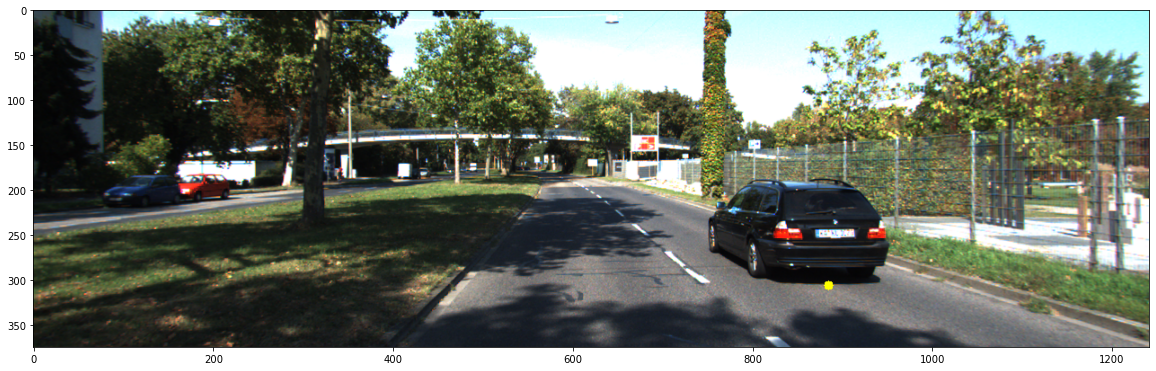

In [37]:
#Converting the point to image co-ordinates to verify
xi = K@Tc_mid
print(xi) 

%matplotlib inline
fig = plt.figure(figsize=(20,30))
image = plt.imread('q3/image.png')
thickness = 5
colour = [255,255,0]
image = cv2.circle(image,(int(xi[0][0]),int(xi[1][0])),thickness,colour,-1)
plt.imshow(image)